# BÁO CÁO MÔN CƠ SỞ TRÍ TUỆ NHÂN TẠO.

# Chọn 2 agent học tăng cường.

##  Mô tả thuật toán và lý do lựa chọn

### 1.1 Bài toán học tăng cường

Bài toán học tăng cường (Reinforcement Learning - RL) được mô hình hóa dưới dạng một quá trình quyết định Markov (Markov Decision Process - MDP), gồm 5 thành phần:

$$
\left( \mathcal{S}, \mathcal{A}, P, R, \gamma \right)
$$

Trong đó:

- $\mathcal{S}$: tập hợp trạng thái.  
- $\mathcal{A}$: tập hợp hành động.  
- $P(s' \mid s, a)$: xác suất chuyển sang trạng thái $s'$ khi thực hiện hành động $a$ tại trạng thái $s$.  
- $R(s, a)$: phần thưởng nhận được khi thực hiện hành động $a$ tại trạng thái $s$.  
- $\gamma \in [0, 1]$: hệ số chiết khấu (discount factor), phản ánh mức độ ưu tiên phần thưởng tương lai.

Mục tiêu của agent là học được một **chính sách** (policy) sao cho tối đa hóa kỳ vọng tổng phần thưởng trong dài hạn:

$$
G_t = \mathbb{E} \left[ \sum_{k=0}^{\infty} \gamma^k R_{t+k+1} \right]
$$

Chính sách này được ký hiệu là $\pi(a \mid s)$ — xác suất chọn hành động $a$ khi ở trạng thái $s$.

---

### 1.2 Deep Q-Network (DQN)

DQN là sự kết hợp giữa **Q-Learning** và **mạng nơ-ron sâu** để xấp xỉ hàm giá trị hành động tối ưu $Q^*(s, a)$. Thay vì lưu bảng Q-values, DQN sử dụng một mạng nơ-ron $Q_\theta(s, a)$ với tham số $\theta$.

Hàm mất mát dùng để cập nhật mạng:

$$
\mathcal{L}(\theta) = \mathbb{E}_{(s,a,r,s') \sim D} \left[ \left( r + \gamma \max_{a'} Q_{\theta^-}(s', a') - Q_\theta(s, a) \right)^2 \right]
$$

Trong đó:

- $Q_{\theta^-}$ là **mạng mục tiêu** (target network), được cập nhật định kỳ từ $Q_\theta$.
- $D$ là **replay buffer**, lưu trữ các trải nghiệm $(s, a, r, s')$.

**Lý do chọn DQN:**

- Hiệu quả trên không gian trạng thái liên tục như LunarLander do không rời rạc hóa không gian trạng thái như Q-Learning.
- Được xác nhận qua nhiều benchmark RL uy tín.

---

### 1.3 Double DQN

DQN có xu hướng **đánh giá quá cao Q-value** vì dùng cùng một mạng để chọn và đánh giá hành động:

$$
\max_{a'} Q_\theta(s', a')
$$

**Double DQN** khắc phục bằng cách **tách chọn và đánh giá hành động**:

$$
\mathcal{L}_{\text{DDQN}}(\theta) = \mathbb{E}_{(s,a,r,s')} \left[ \left( r + \gamma Q_{\theta^-}\left(s', \arg\max_{a'} Q_\theta(s', a') \right) - Q_\theta(s, a) \right)^2 \right]
$$

- $Q_\theta$ chọn hành động tốt nhất: $\arg\max_{a'} Q_\theta(s', a')$
- $Q_{\theta^-}$ đánh giá hành động đó: $Q_{\theta^-}(s', a')$

**Lý do chọn Double DQN:**

- Ổn định hơn, đặc biệt với phần thưởng nhiễu.
- Giảm hiện tượng **overestimation**, giúp học hiệu quả hơn.

---

### 1.4 Tổng kết

| Thuật toán     | Ưu điểm                               | Nhược điểm                        |
|----------------|----------------------------------------|-----------------------------------|
| **DQN**        | Đơn giản, hiệu quả, dễ cài đặt         | Có thể đánh giá quá cao Q-value  |
| **Double DQN** | Ổn định hơn, giảm overestimation       | Phải quản lý 2 mạng riêng biệt   |

---

Vì vậy: Trong báo cáo này, cả **DQN** và **Double DQN** đều được triển khai, huấn luyện và so sánh để tìm ra phương án tối ưu cho môi trường **LunarLander**.


# Import thư viện và xây dựng các hàm phụ trợ.

In [ ]:
# ✅ Import các thư viện cần thiết

# Môi trường mô phỏng
import gymnasium as gym

# Hiển thị và trực quan hóa
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Xử lý số và ngẫu nhiên
import numpy as np
import random

# PyTorch - Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Thanh tiến trình
from tqdm.notebook import trange  # Nếu chạy script thì dùng: from tqdm import trange

# Cấu trúc dữ liệu
from collections import deque


In [ ]:
# Phần thầy cung cấp sẵn.
# Tạo chính sách ngẫu nhiên.
class RandomPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def __call__(self, observation):
        return self.action_space.sample()

# Tạo lớp EpisodeRenderer để chạy một tập và tạo hoạt hình từ các khung hình.
class EpisodeRenderer:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy

    def run_episode(self):
        observation, info = self.env.reset()
        frames = []

        # Run one episode
        done = False
        count = 0
        total_reward = 0
        while not done:
            action = self.policy(observation)  # Replace with your agent's action
            observation, reward, terminated, truncated, info = self.env.step(action)
            frame = self.env.render()  # Get frame as NumPy array
            frames.append(frame)
            count += 1
            total_reward += reward
            done = terminated or truncated

        return dict(
            frames=frames,
            length=count,
            total_reward=total_reward,
            
        )

    def generate_animation(self, frames):
        fig, ax = plt.subplots()
        ax.axis("off")
        img = ax.imshow(frames[0])
        
        # Animation function
        def update(frame):
            img.set_array(frame)
            return [img]
        
        # Create animation
        ani = animation.FuncAnimation(fig, update, frames=frames, interval=50, blit=True)
        return ani

In [3]:
# Vẽ biểu đồ theo dõi Reward qua các episodes trong quá trình huấn luyện.
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Total Reward per Episode")
    plt.plot(np.convolve(rewards, np.ones(20)/20, mode='valid'), label="Moving Avg (20)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Performance")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# Hàm ghi video nhiều tập và lưu thành 1 file mp4
import gymnasium as gym
import torch
import imageio
import os



# Hàm ghi video nhiều tập và lưu thành 1 file mp4
def record_multiple_episodes(env, policy, num_episodes=5, save_path="lander_combined.mp4", fps=30):
    all_frames = []

    for ep in range(1, num_episodes + 1):
        obs, _ = env.reset()
        frames = []
        done = False
        total_reward = 0
        steps = 0

        while not done:
            frame = env.render()
            frames.append(frame)
            action = policy(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated

        all_frames.extend(frames)
        print(f"🎬 Episode {ep} - Steps: {steps} | Reward: {total_reward:.2f}")

    # Tạo thư mục nếu cần
    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

    # Ghi toàn bộ frame thành video
    imageio.mimsave(save_path, all_frames, fps=fps)
    print(f"✅ Video saved to: {save_path}")


In [14]:
# Chính sách DQN từ model đã train để chọn hành động.
class dqNPolicy:
    def __init__(self, model):
        self.model = model

    def __call__(self, observation):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(observation).unsqueeze(0)
            q_values = self.model(state_tensor)
            action = q_values.argmax().item()
        return action

In [11]:
# Đánh giá tỉ lệ hạ cánh thành công (điểm > 200) và hiệu suất nhiên liệu
class LandingEvaluator:
    def __init__(self, env, policy, success_threshold=200):
        self.env = env
        self.policy = policy
        self.success_threshold = success_threshold

    def evaluate(self, num_episodes=100):
        success_count = 0
        total_rewards = []

        for i in range(num_episodes):
            obs, _ = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self.policy(obs)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                episode_reward += reward
                done = terminated or truncated

            total_rewards.append(episode_reward)
            # Kiểm tra nếu episode thành công
            
            if episode_reward >= self.success_threshold:
                success_count += 1
            
            # else:
            #     print(f"Episode {i + 1}: Failed landing with reward {episode_reward:.2f}")
        success_rate = success_count / num_episodes
        avg_reward = sum(total_rewards) / num_episodes

        print(f"📊 Landing Evaluator")
        print(f"✅ Success rate: {success_rate:.2%} ({success_count}/{num_episodes})")
        print(f"🏆 Avg reward: {avg_reward:.2f}")


class FuelEfficiencyEvaluator:
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy

    def evaluate(self, num_episodes=100):
        main_engine_counts = []
        episode_lengths = []

        for _ in range(num_episodes):
            obs, _ = self.env.reset()
            done = False
            main_engine_used = 0
            steps = 0

            while not done:
                action = self.policy(obs)
                if action == 2:
                    main_engine_used += 1

                obs, _, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                steps += 1

            main_engine_counts.append(main_engine_used)
            episode_lengths.append(steps)

        avg_main_engine = sum(main_engine_counts) / num_episodes
        avg_steps = sum(episode_lengths) / num_episodes
        avg_ratio = avg_main_engine / avg_steps

        print(f"⛽ Fuel Efficiency Evaluator")
        print(f"🔁 Avg steps per episode: {avg_steps:.2f}")
        print(f"🔥 Avg main engine uses: {avg_main_engine:.2f}")
        print(f"📉 Avg main engine usage rate: {avg_ratio:.2%}")




In [12]:
# kiểm tra hạ cánh thành công với điều kiện cả 2 chân chạm đất an toàn 

def is_successful_landing(state, terminated):
    if not terminated:
        return False
    _, _, vx, vy, theta, _, left_contact, right_contact = state
    return left_contact == 1.0 and right_contact == 1.0

def evaluate_success_rate(policy, env_name="LunarLander-v3", episodes=100):
    success_count = 0
    total_reward_list = []

    # Dùng render_mode=None để tăng tốc
    env = gym.make(env_name, render_mode=None)

    for ep in range(episodes):
        state, _ = env.reset()
        terminated = truncated = False
        total_reward = 0

        while not (terminated or truncated):
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            state = next_state

        if is_successful_landing(state, terminated):
            success_count += 1

        total_reward_list.append(total_reward)

    env.close()

    success_rate = success_count / episodes
    avg_reward = np.mean(total_reward_list)

    print(f"✅ Số lần hạ cánh an toàn: {success_count}/{episodes} ({success_rate * 100:.2f}%)")
    print(f"🎯 Trung bình reward: {avg_reward:.2f}")

    return success_rate, avg_reward


# Xây dựng và huấn luyện mô hình DQN.

In [ ]:
# ✅ Mạng DQN: Đây là mô hình mạng nơ-ron sâu dùng để ước lượng giá trị Q (Q-values) cho mỗi hành động có thể thực hiện trong một trạng thái cụ thể.
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        # Mạng nơ-ron có 3 lớp: 2 lớp ẩn với 128 neuron và hàm kích hoạt ReLU
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),  # Lớp đầu vào: từ trạng thái -> 128 giá trị
            nn.ReLU(),
            nn.Linear(128, 128),        # Lớp ẩn thứ hai
            nn.ReLU(),
            nn.Linear(128, action_dim)  # Lớp đầu ra: đưa ra giá trị Q cho mỗi hành động
        )

    def forward(self, x):
        # Hàm lan truyền tiến để đưa ra Q-value tương ứng với mỗi hành động
        return self.model(x)

# ✅ Bộ nhớ hồi tiếp (Replay Buffer): Lưu trữ các kinh nghiệm (transition) để huấn luyện lại
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        # Dùng deque để lưu trữ tối đa 'capacity' mẫu
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Thêm một mẫu (transition) vào buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        # Lấy ngẫu nhiên một batch mẫu để huấn luyện
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=np.uint8))

    def __len__(self):
        # Trả về số lượng mẫu đang lưu
        return len(self.buffer)

# ✅ Hàm huấn luyện: Dùng thuật toán DQN để huấn luyện agent chơi game
def train_dqn(env, episodes=600, batch_size=64, gamma=0.99, 
              lr=0.0001, epsilon_start=1.0, epsilon_end=0.01, 
              epsilon_decay=500, target_update_freq=10):

    # Kiểm tra xem có GPU không, nếu có thì dùng
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Lấy số chiều của trạng thái và số hành động của môi trường
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Khởi tạo hai mạng DQN: policy_net để dự đoán, target_net để cập nhật mục tiêu
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())  # Ban đầu cho hai mạng giống nhau
    target_net.eval()  # target_net chỉ dùng để dự đoán nên không cần cập nhật gradient

    # Bộ tối ưu và bộ nhớ hồi tiếp
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer()
    steps_done = 0  # Biến đếm số bước đã thực hiện
    rewards = []    # Lưu tổng phần thưởng của mỗi episode

    # Vòng lặp huấn luyện qua nhiều episode
    for episode in trange(episodes, desc="Training DQN"):
    
        state, _ = env.reset()  # Reset lại môi trường
        total_reward = 0

        # Mỗi episode chạy tối đa 1000 bước
        for t in range(1000):
            # Tính toán epsilon theo hàm mũ để giảm dần mức độ chọn hành động ngẫu nhiên
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                      np.exp(-1. * steps_done / epsilon_decay)

            # Chọn hành động: thám hiểm (random) hoặc khai thác (dựa trên policy_net)
            if random.random() < epsilon:
                action = env.action_space.sample()  # Chọn hành động ngẫu nhiên
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()  # Chọn hành động có Q-value cao nhất

            # Thực hiện hành động và nhận phản hồi từ môi trường
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Kiểm tra nếu episode kết thúc

            # Lưu mẫu vào bộ nhớ
            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            # Chỉ huấn luyện khi đủ số lượng mẫu trong bộ nhớ
            if len(memory) >= batch_size:
                states, actions, rewards_batch, next_states, dones = memory.sample(batch_size)

                # Chuyển dữ liệu thành tensor
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_batch = torch.FloatTensor(rewards_batch).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                # Tính Q(s,a) bằng policy_net
                q_values = policy_net(states).gather(1, actions).squeeze()

                # Tính giá trị mục tiêu: r + γ * max_a' Q_target(s', a') nếu không kết thúc
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    expected_q = rewards_batch + (1 - dones) * gamma * next_q_values

                # Hàm mất mát MSE
                loss = nn.MSELoss()(q_values, expected_q)

                # Tính gradient và cập nhật trọng số
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # Giới hạn gradient tránh exploding
                optimizer.step()

            if done:
                break  # Kết thúc nếu environment báo done

        # Cập nhật mạng mục tiêu định kỳ
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards.append(total_reward)  # Ghi lại tổng phần thưởng của episode hiện tại

    # Trả về policy_net đã được huấn luyện và danh sách phần thưởng
    return policy_net, rewards


In [ ]:
# Huấn luyện với DQN xây dựng bên trên.
env = gym.make("LunarLander-v3")
trained_model_dqn, reward_dqn_history = train_dqn(env, episodes=3000)
 

Using device: cpu


Training DQN: 100%|██████████| 3000/3000 [1:14:35<00:00,  1.49s/it]


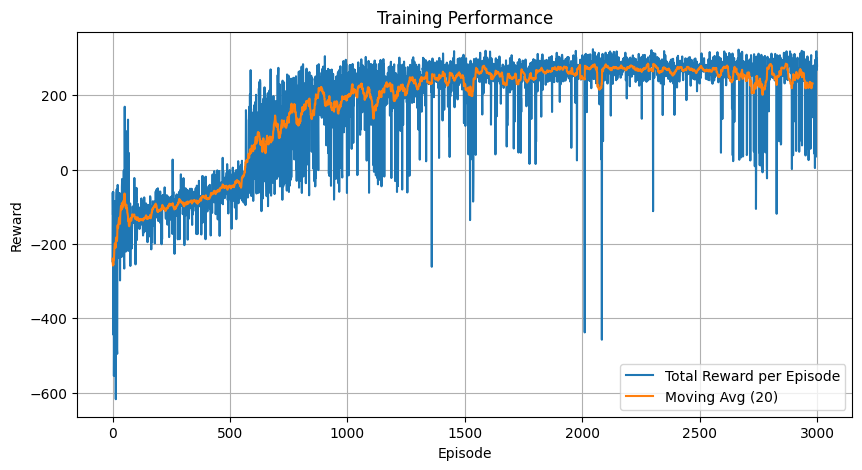

In [152]:
# kết quả huấn luyện. 
plot_rewards(reward_dqn_history)

In [ ]:
# đánh giá vs đkien 2 chân chạm đất.

policy = dqNPolicy(trained_model_dqn)

# Đánh giá trong 1000 episode
_ = evaluate_success_rate(policy, episodes=1000)

✅ Số lần hạ cánh an toàn: 867/1000 (86.70%)
🎯 Trung bình reward: 219.84



In [ ]:
# >200d và sử dụng nhiên liệu.

env_eval = gym.make("LunarLander-v3")

policy = dqNPolicy(trained_model_dqn)

# Đánh giá tỷ lệ hạ cánh >200 điểm.
landing_eval = LandingEvaluator(env_eval, policy, success_threshold=200)
landing_eval.evaluate(num_episodes=1000)
print()
# Đánh giá hiệu quả nhiên liệu
fuel_eval = FuelEfficiencyEvaluator(env_eval, policy)
fuel_eval.evaluate(num_episodes=1000)

env_eval.close()

📊 Landing Evaluator
✅ Success rate: 85.40% (854/1000)
🏆 Avg reward: 210.32

⛽ Fuel Efficiency Evaluator
🔁 Avg steps per episode: 300.76
🔥 Avg main engine uses: 129.03
📉 Avg main engine usage rate: 42.90%


video: https://youtu.be/ZfU8pcwYWqw

# Xây dựng và huấn luyện mô hình Double DQN.

In [ ]:
# xây dựng mô hình. 
# Double DQN cho môi trường LunarLander-v3, có thêm cơ chế dừng sớm (early stopping) và ưu tiên học từ những lần thất bại (failure-focused training)



# Thiết lập hạt giống ngẫu nhiên để tái lập được kết quả (giúp chạy lại ra cùng kết quả)
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # Nếu có GPU thì đặt seed cho cả GPU
        torch.cuda.manual_seed(seed)
set_seed()  # Gọi hàm luôn khi bắt đầu

# Replay Buffer: nơi lưu lại kinh nghiệm (các bước agent đã đi qua)
# Bổ sung thêm fail_buffer: lưu riêng các lần thất bại để ưu tiên học từ đó
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)  # Bộ nhớ chính
        self.fail_buffer = deque(maxlen=capacity // 5)  # Bộ nhớ lưu riêng các bước thất bại

    # Ghi lại một bước (transition): (trạng thái, hành động, phần thưởng, trạng thái tiếp theo, kết thúc?, có thất bại không)
    def push(self, state, action, reward, next_state, done, is_failure=False):
        self.buffer.append((state, action, reward, next_state, done))
        if is_failure:  # Nếu đây là bước thất bại, lưu thêm vào fail_buffer
            self.fail_buffer.append((state, action, reward, next_state, done))

    # Lấy ra một batch dữ liệu để huấn luyện. Nếu cần, ưu tiên lấy thêm từ các bước thất bại
    def sample(self, batch_size, failure_focus=False):
        if not failure_focus or len(self.fail_buffer) < batch_size * 0.3:
            batch = random.sample(self.buffer, batch_size)  # Lấy toàn bộ từ buffer chính
        else:
            batch_main = random.sample(self.buffer, int(batch_size * 0.7))  # 70% từ buffer chính
            batch_fail = random.sample(self.fail_buffer, int(batch_size * 0.3))  # 30% từ thất bại
            batch = batch_main + batch_fail

        # Chuyển danh sách thành mảng numpy
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

# Mạng DQN cơ bản với 2 lớp ẩn 256 neurons
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)  # Lớp ẩn 1
        self.fc2 = nn.Linear(256, 256)  # Lớp ẩn 2
        self.out = nn.Linear(256, action_dim)  # Lớp đầu ra: số lượng hành động

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Kích hoạt ReLU
        x = F.relu(self.fc2(x))
        return self.out(x)  # Trả về giá trị Q tương ứng với mỗi hành động

# Agent sử dụng Double DQN để chọn hành động và huấn luyện
class DoubleDQNAgent:
    def __init__(self, state_dim, action_dim, lr=5e-4, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.05):
        self.action_dim = action_dim  # Số hành động
        self.gamma = gamma  # Hệ số chiết khấu
        self.epsilon = epsilon  # Xác suất chọn hành động ngẫu nhiên (exploration)
        self.epsilon_decay = epsilon_decay  # Tốc độ giảm epsilon sau mỗi episode
        self.min_epsilon = min_epsilon  # Epsilon nhỏ nhất

        # Dùng GPU nếu có, nếu không thì dùng CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Mạng chính để chọn hành động
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        # Mạng mục tiêu: dùng để tính giá trị Q mục tiêu
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Ban đầu giống nhau
        self.target_net.eval()  # Không huấn luyện mạng mục tiêu

        # Bộ tối ưu hóa Adam và hàm mất mát Huber
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber loss: ổn định hơn MSE

    # Chọn hành động theo epsilon-greedy
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)  # Chọn ngẫu nhiên
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()  # Chọn hành động có Q-value cao nhất

    # Huấn luyện agent từ replay buffer
    def train(self, replay_buffer, batch_size=64, failure_focus=False):
        if len(replay_buffer) < batch_size:
            return  # Không đủ dữ liệu để huấn luyện

        # Lấy ra một batch dữ liệu
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size, failure_focus)
        # Chuyển sang tensor
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Double DQN: hành động tốt nhất được chọn từ policy_net, nhưng giá trị được lấy từ target_net
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q = rewards + (1 - dones) * self.gamma * next_q_values  # Tính Q mục tiêu

        # Tính Q hiện tại từ policy_net
        q_values = self.policy_net(states).gather(1, actions)

        # Tính hàm mất mát và cập nhật mạng
        loss = self.loss_fn(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Hàm huấn luyện chính
def train_double_dqn(env, agent, episodes=2000, batch_size=64, target_update=10):
    replay_buffer = ReplayBuffer()
    recent_rewards = deque(maxlen=100)  # Lưu 100 phần thưởng gần nhất để kiểm tra dừng sớm
    all_rewards = []  # Lưu phần thưởng toàn bộ quá trình
    in_failure_focus_mode = False  # Chưa bật chế độ tập trung vào thất bại

    for episode in trange(1, episodes + 1):  # Vòng lặp qua từng episode
        state, _ = env.reset()
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Agent chọn hành động
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated  # Xác định kết thúc

            # Không chỉnh reward (theo yêu cầu bài toán)
            is_failure = False

            total_reward += reward
            step_count += 1

            state_tuple = (state, action, reward, next_state, done)
            state = next_state

            # Sau khi biết reward mới xác định có phải lần thất bại không
            if done:
                is_failure = total_reward < 200 or step_count >= 1000
            replay_buffer.push(*state_tuple, is_failure=is_failure)

            # Huấn luyện từng bước
            agent.train(replay_buffer, batch_size, failure_focus=in_failure_focus_mode)

        # Giảm epsilon (ít dần việc chọn hành động ngẫu nhiên)
        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
        recent_rewards.append(total_reward)
        all_rewards.append(total_reward)

        # Cập nhật mạng mục tiêu mỗi vài episode
        if episode % target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        # Kiểm tra dừng sớm: nếu 100 lần gần nhất đều > 200 điểm
        if len(recent_rewards) == 100:
            if all(r > 200 for r in recent_rewards):
                print(f"\n✅ Early stop at episode {episode}: all 100 recent rewards > 200")
                break
            # Bật chế độ tập trung vào thất bại nếu đã ổn định > 200 điểm
            elif not in_failure_focus_mode and np.mean(recent_rewards) > 200 and episode > 700:
                print(f"\n⚠️ Switching to failure-focused training at episode {episode} (avg reward > 200)")
                in_failure_focus_mode = True

    return all_rewards, agent  # Trả về lịch sử phần thưởng và agent cuối cùng


In [ ]:
# Huấn luyện mô hình vừa tạo.
env = gym.make("LunarLander-v3")
agent = DoubleDQNAgent(state_dim=8, action_dim=4)

rewards_3000, trained_agent_3000 = train_double_dqn(env, agent, episodes=3000)


 23%|██▎       | 701/3000 [24:04<58:32,  1.53s/it]  


⚠️ Switching to failure-focused training at episode 701 (avg reward > 200)


100%|██████████| 3000/3000 [1:44:56<00:00,  2.10s/it]  


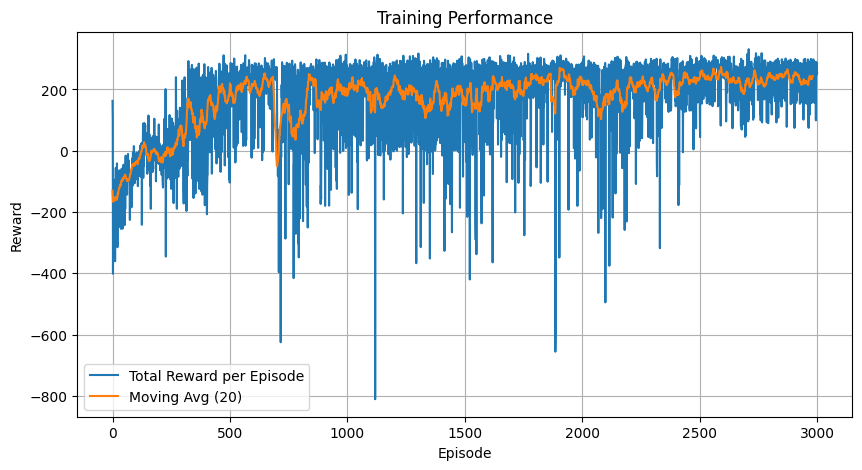

In [ ]:
# Kết quả huấn luyện

plot_rewards(rewards_3000)

In [ ]:
# đánh giá vs điều kiện 2 chân chạm đất.

policy = dqNPolicy(trained_agent_3000)

# Đánh giá trong 1000 episode
_ = evaluate_success_rate(policy, episodes=1000)

✅ Số lần hạ cánh an toàn: 989/1000 (98.90%)
🎯 Trung bình reward: 257.43



In [ ]:
# >200d và sử dụng nhiên liệu.
# policy là class có method __call__(observation) -> action
env_eval = gym.make("LunarLander-v3")
policy = dqNPolicy(trained_agent_3000)

# Đánh giá tỷ lệ hạ cánh >200 điểm.
landing_eval = LandingEvaluator(env_eval, policy, success_threshold=200)
landing_eval.evaluate(num_episodes=1000)

print()

# Đánh giá hiệu quả nhiên liệu
fuel_eval = FuelEfficiencyEvaluator(env_eval, policy)
fuel_eval.evaluate(num_episodes=1000)

env_eval.close()

📊 Landing Evaluator
✅ Success rate: 94.70% (947/1000)
🏆 Avg reward: 261.03

⛽ Fuel Efficiency Evaluator
🔁 Avg steps per episode: 210.88
🔥 Avg main engine uses: 102.06
📉 Avg main engine usage rate: 48.40%


link video: https://youtu.be/C72-WWXBqdM

# Điều chỉnh lần 1: chuyển gamma từ 0.99 -> 0.95.
#### mô hình không xem xét được chiến lược dài hạn, không thể tiếp đất được.


In [7]:
# Huấn luyện với DQN xây dựng bên trên.
env = gym.make("LunarLander-v3")
trained_model_dqn_gamma, reward_dqn_history_gamma = train_dqn(env, episodes=3000, gamma=0.95 )

Using device: cpu


Training DQN: 100%|██████████| 3000/3000 [2:20:20<00:00,  2.81s/it]  


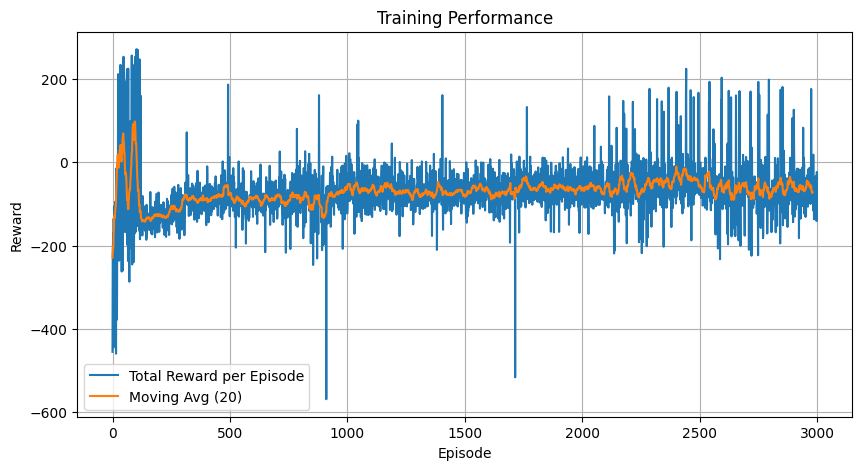

In [8]:
# kết quả huấn luyện.
plot_rewards(reward_dqn_history_gamma)

In [ ]:
# đánh giá vs điều kiện 2 chân chạm đất.

policy = dqNPolicy(trained_model_dqn_gamma)

# Đánh giá trong 50 episode
_ = evaluate_success_rate(policy, episodes=50)

✅ Số lần hạ cánh an toàn: 0/50 (0.00%)
🎯 Trung bình reward: -54.65



In [ ]:
# >200d và sử dụng nhiên liệu.
# policy là class có method __call__(observation) -> action
env_eval = gym.make("LunarLander-v3")
policy = dqNPolicy(trained_model_dqn_gamma)

# Đánh giá tỷ lệ hạ cánh >200 điểm.
landing_eval = LandingEvaluator(env_eval, policy, success_threshold=200)
landing_eval.evaluate(num_episodes=50)

print()

# Đánh giá hiệu quả nhiên liệu
fuel_eval = FuelEfficiencyEvaluator(env_eval, policy)
fuel_eval.evaluate(num_episodes=50)

env_eval.close()

📊 Landing Evaluator
✅ Success rate: 0.00% (0/50)
🏆 Avg reward: -66.56

⛽ Fuel Efficiency Evaluator
🔁 Avg steps per episode: 937.04
🔥 Avg main engine uses: 552.41
📉 Avg main engine usage rate: 58.95%


link video: https://youtu.be/aJ1W4MqRoLI

# Điều chỉnh lần 2 -> thêm 20 hành động ban đầu là ngẫu nhiên -> cải thiện tỉ lệ thành công từ 85% -> 95%.

**khi được thêm 20 hành động ngẫu nhiên ban đầu, mô hình học được cách nhanh chóng di chuyển về khu vực x xấp xỉ 0 (tức là ở giữa 2 cờ) ngay từ mãi trên không, từ đó tăng hiệu suất hạ cánh và tránh tình trạng đã tiếp đất nhưng cứ chỉ bật 1 động cơ bên phải/trái để mong muốn đẩy tàu vũ trụ vào giữa 2 lá cờ.**

In [ ]:
# Huấn luyện Deep Q-Network (DQN) với 20 hành động đầu tiên mỗi episode là ngẫu nhiên

def train_dqn(env, episodes=600, batch_size=64, gamma=0.99, 
              lr=0.0001, epsilon_start=1.0, epsilon_end=0.01, 
              epsilon_decay=500, target_update_freq=10, random_steps=20):
    """
    Huấn luyện agent với thuật toán DQN.
    
    Tham số:
        env: môi trường học tăng cường
        episodes: số tập huấn luyện
        batch_size: kích thước minibatch khi huấn luyện
        gamma: hệ số chiết khấu
        lr: learning rate
        epsilon_start, epsilon_end, epsilon_decay: tham số cho epsilon-greedy
        target_update_freq: số tập giữa mỗi lần cập nhật target network
        random_steps: số bước đầu tiên chọn hành động ngẫu nhiên
    """

    # Tự động sử dụng GPU nếu có
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Lấy số chiều của trạng thái và số lượng hành động
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Khởi tạo mạng chính và mạng mục tiêu
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())  # copy trọng số ban đầu
    target_net.eval()  # không cần gradient cho mạng mục tiêu

    # Khởi tạo optimizer và bộ nhớ kinh nghiệm
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer()
    steps_done = 0  # đếm số bước đã thực hiện (cho epsilon decay)
    rewards = []    # lưu reward của mỗi tập

    # Bắt đầu huấn luyện qua các tập
    for episode in trange(episodes, desc="Training DQN"):
        state, _ = env.reset()
        total_reward = 0

        for t in range(1000):  # giới hạn số bước trong mỗi tập
            if t < random_steps:
                # Trong random_steps đầu tiên, luôn chọn hành động ngẫu nhiên
                action = env.action_space.sample()
            else:
                # Tính toán epsilon theo công thức decay
                epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                          np.exp(-1. * steps_done / epsilon_decay)

                # Áp dụng chiến lược epsilon-greedy
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        q_values = policy_net(state_tensor)
                        action = q_values.argmax().item()

            # Thực hiện hành động trong môi trường
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Chỉ bắt đầu lưu kinh nghiệm vào replay buffer sau random_steps
            if t >= random_steps:
                memory.push(state, action, reward, next_state, done)

            # Cập nhật trạng thái
            state = next_state
            total_reward += reward
            steps_done += 1

            # Nếu đủ dữ liệu trong buffer, tiến hành huấn luyện từ minibatch
            if len(memory) >= batch_size:
                # Lấy minibatch ngẫu nhiên
                states, actions, rewards_batch, next_states, dones = memory.sample(batch_size)

                # Chuyển sang tensor và đưa lên thiết bị
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_batch = torch.FloatTensor(rewards_batch).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.FloatTensor(dones).to(device)

                # Tính Q-value của hành động đã chọn
                q_values = policy_net(states).gather(1, actions).squeeze()

                # Tính Q-value mục tiêu với Bellman equation
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    expected_q = rewards_batch + (1 - dones) * gamma * next_q_values

                # Tính loss và cập nhật trọng số mạng chính
                loss = nn.MSELoss()(q_values, expected_q)

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()

            # Nếu tập kết thúc, thoát vòng lặp
            if done:
                break

        # Cập nhật mạng mục tiêu định kỳ
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Ghi lại phần thưởng của tập
        rewards.append(total_reward)

    # Trả về mạng đã huấn luyện và danh sách reward để vẽ biểu đồ
    return policy_net, rewards


In [ ]:
# huấn luyện mô hình vừa tạo 
trained_model_dqn_random20, reward_dqn_history_random20 = train_dqn(env, episodes=3000, random_steps=20)


Using device: cpu


Training DQN: 100%|██████████| 3000/3000 [1:59:12<00:00,  2.38s/it]  


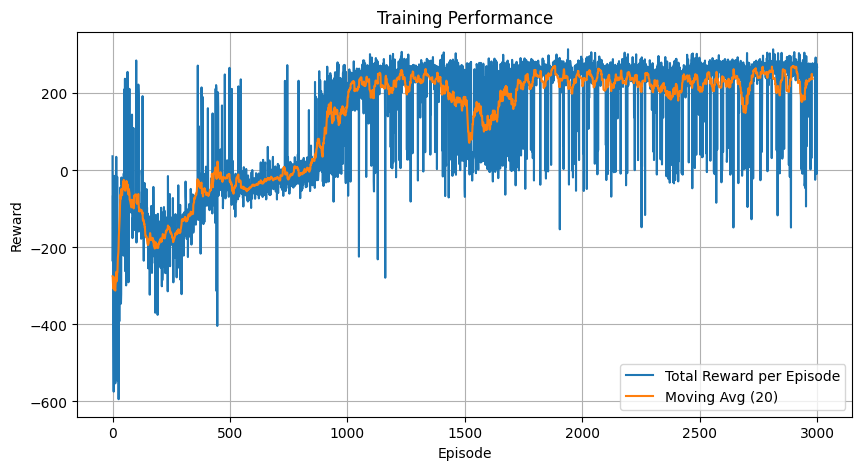

In [ ]:
# Kết quả huấn luyện.
plot_rewards(reward_dqn_history_random20)

In [ ]:
# đánh giá vs đkien 2 chân chạm đất.
# Giả sử bạn đã có trained_model
policy = dqNPolicy(trained_model_dqn_random20)

# Đánh giá trong 1000 episode
_ = evaluate_success_rate(policy, episodes=1000)

✅ Số lần hạ cánh an toàn: 975/1000 (97.50%)
🎯 Trung bình reward: 264.16



In [ ]:
# >200d và sử dụng nhiên liệu.
# policy là class có method __call__(observation) -> action
env_eval = gym.make("LunarLander-v3")
policy = dqNPolicy(trained_model_dqn_random20)

# Đánh giá tỷ lệ hạ cánh >200 điểm.
landing_eval = LandingEvaluator(env_eval, policy, success_threshold=200)
landing_eval.evaluate(num_episodes=1000)

print()

# Đánh giá hiệu quả nhiên liệu
fuel_eval = FuelEfficiencyEvaluator(env_eval, policy)
fuel_eval.evaluate(num_episodes=1000)

env_eval.close()

📊 Landing Evaluator
✅ Success rate: 95.80% (958/1000)
🏆 Avg reward: 252.83

⛽ Fuel Efficiency Evaluator
🔁 Avg steps per episode: 240.66
🔥 Avg main engine uses: 132.45
📉 Avg main engine usage rate: 55.04%


link youtube: https://youtu.be/FwU_73A31jQ